# Semantic image segmentation using OpenEarthMap imagery and U-Net with Efficient Net B4 backbone

In [1]:
import numpy as np
import pandas as pd
import pyreadr as pyr
from sys import getsizeof
import random
import cv2
import os
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import segmentation_models as sm # 
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from patchify import patchify

sm.set_framework('tf.keras')
sm.framework()
random_seed = 1234

Segmentation Models: using `keras` framework.


## Import OpenEarthMap

The data can be downloaded from the following [website](https://open-earth-map.org/). The image segmentation masks contain 9 categories. Most of the images have a size of 1024x1024. However, some have the size 1000x1000 or 650x650. After loading the data a preprocessing pipeline is used to transform all images to a size of 512x512. Images of size 1024x1024 are patchified into four imags of equal size. To images of size 1000x1000 zero padding is added and they are patchified into four imags of equal size. If the image size is 650x650 a central crop is applied. This results in 5629 images and masks from developing countries and 3649 from developed countries and a total of 9278 examples. Due to the small size of the data set 5-fold cross validation is used later on to evaluate the models performance.

* 0 Unknown
* 1 Bareland
* 2 Rangeland
* 3 Developed space
* 4 Road
* 5 Trees
* 6 Water
* 7 Agriculture land
* 8 Buildings

In [2]:
developing_countries = ["abancay","accra","al_qurnah","baybay","bogota","buenos_aires","chiangmai","chiclayo","chincha","coxsbazar",
                        "daressalaam","dhaka","dowa","ica","kagera","kampala","khartoum","kyoto","lambayeque","lima","lohur","mahe",
                        "maputo","monrovia","ngaoundere","niamey","pisco","piura","pointenoire","rosario","san_tome","santiago",
                        "sechura","soriano","svaneti","tokyo","tonga","ulaanbaatar","viru","western","zanzibar"]

developed_countries = ["aachen","austin","bielefeld","chicago","chisinau","christchurch","dolnoslaskie","dortmund","duesseldorf","koeln",
                       "tyrolw","kujawsko-pomorskie","mazowieckie","melbourne","podkarpackie","podlaskie","pomorskie","rotterdam",
                       "slaskie","swietokrzyskie","vienna","warminsko-mazurskie","wielkopolskie","zachodniopomorskie","paris","shanghai","vegas"]

all_countries = developing_countries+developed_countries

In [3]:
def get_mask_and_image(path, valid_images, city):
    imgs = []
    img_names = []
    img_masks = []

    for f in os.listdir(path+city+"/labels/"):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        img_names.append(f)
        img_masks.append(io.imread(os.path.join(path+city+"/labels/",f)))

    for i in img_names:
        imgs.append(io.imread(path+city+"/images/"+i))
    
    return img_names, img_masks, imgs

In [5]:
city_names=[]
city_masks=[]
city_imgs=[]

for i in all_countries:
    c_names, c_masks, c_imgs = get_mask_and_image("//resstore.unibe.ch/sowi_research_bahr/openearthmap/", [".tif"], i)
    
    if c_imgs[0].shape == (1024,1024,3):
        for img in c_imgs:
            patchified_img = patchify(img, (512, 512, 3), step=512)
            for k in range(patchified_img.shape[0]):
                for j in range(patchified_img.shape[1]):
                    city_imgs.append(patchified_img[k, j,0,:, :, :]) 
            
        for mask in c_masks:
            patchified_mask = patchify(np.expand_dims(mask, axis=2), (512, 512, 1), step=512)           
            for k in range(patchified_mask.shape[0]):
                for j in range(patchified_mask.shape[1]):
                    city_masks.append(patchified_mask[k, j,0,:, :, :])
            
        for n in c_names:
            for n_i in range(0, 4):
                city_names.append(n.split(".")[0])
        print(i)
        
    elif c_imgs[0].shape == (1000,1000,3):
        for n in c_names:
            for n_i in range(0, 4):
                city_names.append(n.split(".")[0])             
          
        for img in c_imgs:
            c_img = np.pad(img, pad_width=[(12, 12),(12, 12),(0, 0)], mode='constant', constant_values=0)
            patchified_img = patchify(c_img, (512, 512, 3), step=512) 
            for k in range(patchified_img.shape[0]):
                for j in range(patchified_img.shape[1]):
                    city_imgs.append(patchified_img[k, j,0,:, :, :])
            
        for mask in c_masks:                
            c_mask = np.pad(np.expand_dims(mask, axis=2), pad_width=[(12, 12),(12, 12),(0, 0)], mode='constant', constant_values=0)
            patchified_mask = patchify(c_mask, (512, 512, 1), step=512)
            for k in range(patchified_mask.shape[0]):
                for j in range(patchified_mask.shape[1]):
                    city_masks.append(patchified_mask[k, j,0,:, :, :])
        print(i)
    
    elif c_imgs[0].shape == (650,650,3):
        for img in c_imgs:        
            city_imgs.append(np.array(tf.image.central_crop(img, 0.787)))
            
        for mask in c_masks:
            city_masks.append(np.array(tf.image.central_crop(np.expand_dims(mask, axis=2), 0.787)))
            
        for name in c_names:
            city_names.append(name.split(".")[0])
        print(i)
            
        

city_masks = np.array(city_masks)
city_imgs = np.array(city_imgs)

abancay
accra
al_qurnah
baybay
bogota
buenos_aires
chiangmai
chiclayo
chincha
coxsbazar
daressalaam
dhaka
dowa
ica
kagera
kampala
khartoum
kyoto
lambayeque
lima
lohur
mahe
maputo
monrovia
ngaoundere
niamey
pisco
piura
pointenoire
rosario
san_tome
santiago
sechura
soriano
svaneti
tokyo
tonga
ulaanbaatar
viru
western
zanzibar
aachen
austin
bielefeld
chicago
chisinau
christchurch
dolnoslaskie
dortmund
duesseldorf
koeln
tyrolw
kujawsko-pomorskie
mazowieckie
melbourne
podkarpackie
podlaskie
pomorskie
slaskie
swietokrzyskie
vienna
warminsko-mazurskie
wielkopolskie
zachodniopomorskie
paris
shanghai
vegas


## Distribution of mask segments

In [5]:
value, count = np.unique(np.array(city_masks).flatten(), return_counts=True)

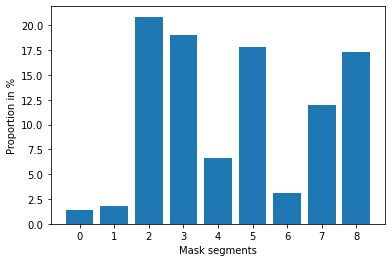

In [12]:
plt.bar([str(x) for x  in value], (count/np.sum(count))*100)
plt.xlabel("Mask segments")
plt.ylabel("Proportion in %")
plt.show()

## Distribution of mask segments in developed countries

In [8]:
isov = pd.read_excel("H:/Sebastian_Bahr/PhD/2_Publication/Crime_and_ML/Data/image_segmentation_city_overview.xlsx")

names = pd.DataFrame([x.rsplit("_")[0] for x in list(city_names)], columns=["city"])
names = names.merge(isov[["city", "developed"]], on="city", how="left")
idx_developed = names[names.developed==1].index  
city_masks_developed = city_masks[idx_developed]

value, count = np.unique(np.array(city_masks_developed).flatten(), return_counts=True)

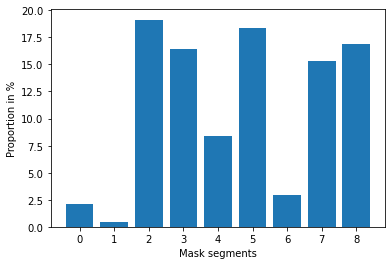

In [9]:
plt.bar([str(x) for x  in value], (count/np.sum(count))*100)
plt.xlabel("Mask segments")
plt.ylabel("Proportion in %")
plt.show()

## Encode mask

Encode the 1 dimensional to a 9 dimensional mask using one-hot-encoding.

In [13]:
labelencoder = LabelEncoder()
n, h, w = city_masks[:,:,:,0].shape
city_masks_reshaped = np.array(city_masks).reshape(-1,1)
city_masks_reshaped_encoded = labelencoder.fit_transform(city_masks_reshaped)
city_masks_encoded = city_masks_reshaped_encoded.reshape(n, h, w)
city_masks_input = np.expand_dims(city_masks_encoded, axis=3)

C:\Users\bahr\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
n_classes = 9
city_masks_cat = tf.keras.utils.to_categorical(city_masks_input, num_classes=n_classes)
city_masks_cat = city_masks_cat.astype("uint8")

# check shape
city_masks_cat.shape

(9278, 512, 512, 9)

## Randomly shuffle the data 

In [15]:
np.random.seed(random_seed)
idx = np.random.permutation(len(city_imgs))
city_names_shuffled = np.array(city_names)[idx]
city_imgs_shuffled = city_imgs[idx]
city_masks_cat_shuffled = city_masks_cat[idx]

## 5-fold CV data split

In [ ]:
num_folds = 5
i=1
kfold = KFold(n_splits=num_folds, shuffle=False)
for idx_train, idx_test in kfold.split(city_imgs_shuffled, city_masks_cat_shuffled, city_names_shuffled):   
    train_imgs = city_imgs_shuffled[idx_train]
    train_mask = city_masks_cat_shuffled[idx_train]
    test_imgs = city_imgs_shuffled[idx_test]
    test_mask = city_masks_cat_shuffled[idx_test]
    test_names = city_names_shuffled[idx_test]
    np.save("/path/CV%s_train_imgs_all_patch" %i, train_imgs)
    np.save("/path/CV%s_train_mask_all_patch" %i, train_mask)
    np.save("/path/CV%s_test_names_all_patch" %i, test_names)
    np.save("/path/CV%s_test_imgs_all_patch" %i, test_imgs)
    np.save("/path/CV%s_test_mask_all_patch" %i, test_mask)
    i += 1

## Preprocess the data and compile the models in Keras

Due to the high requirement of VRAM the models were trained on the on [UBELIX](http://www.id.unibe.ch/hpc), the HPC cluster at the University of Bern. The same process is repeated for folds 2-5. Most of the hyperparameters are choosen following the suggestion of the original paper of [Xia et al. 2022](https://arxiv.org/abs/2210.10732). However, multiple experiments were run using different backbones and losses. In particulare, the backbone based on an EfficientNet B4 outperformed backbones based on Resnet 34, Resnext 101 and EfficientNet B0. Further, summing focal and jaccard loss outperformed categorical cross entropy, dice loss and combinations of them with focal loss.

In [ ]:
## Set hyperparameter and variables
i = "effnetb4_dice_1" # MC name
m = "effnetb4" # name backbone
batchsize = 8
prefetch = 1
n_classes = 9
n_epoch = 120
lr = 0.0001
decay = 0.000001
metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


## Load data CV1
CV1_train_imgs = np.load("/path/CV1_train_imgs_all_patch.npy")
CV1_train_mask = np.load("/path/CV1_train_mask_all_patch.npy")
CV1_test_imgs = np.load("/path/CV1_test_imgs_all_patch.npy")
CV1_test_mask = np.load("/path/CV1_test_mask_all_patch.npy")


## Data preprocessing
def preprocess_images(image, label):
    label = tf.cast(label, tf.float16)
    image = tf.cast(image, tf.uint8)  
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    image = tf.clip_by_value(image, 0, 255)  
    return(image, label)


with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((CV1_train_imgs, CV1_train_mask))
    train_data = train_data.batch(batchsize, drop_remainder=False)
    train_data = train_data.map(preprocess_images, num_parallel_calls=8)  
    
    test_data = tf.data.Dataset.from_tensor_slices((CV1_test_imgs, CV1_test_mask))
    test_data = test_data.batch(batchsize, drop_remainder=False)
    test_data = test_data.map(preprocess_images, num_parallel_calls=8)
    

with tf.device('/cpu:0'):   
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    
    
with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("/path/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    ## Callbacks
    mc = [tf.keras.callbacks.ModelCheckpoint(filepath="/path/u_net_models_mc/u_net_%s" %i,
                                             save_best_only=True, monitor='val_iou_score', mode='max')] 
    
    
## Train model
with tf.device('/gpu:0'):
    hist = backbone_model.fit(train_data,
                              validation_data=test_data,
                              batch_size=batchsize,
                              epochs=n_epoch,
                              callbacks=[mc],
                              verbose = 0)
    
    
## Model evaluation
with tf.device('/cpu:0'): 
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    def plot_metrics(history):
        metrics = ['loss', 'cat_accuracy', 'iou_score', 'f1-score']
        for n, metric in enumerate(metrics):
            name = metric.replace("_"," ").capitalize()
            plt.subplot(2,2,n+1)
            plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
            plt.xlabel('Epoch')
            plt.ylabel(name)
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.5,1])
            else:
                plt.ylim([0,1])
                
            plt.legend();
            
            
    plot_metrics(hist)
    plt.savefig("/path/performance_plots/u_net_%s" %i)       
      
    
    backbone_model.compile(optimizer=optimizer,
                           loss=dice_loss,
                           metrics=metrics)
    backbone_model.load_weights("/path/u_net_models_mc/u_net_%s" %i)
            
       
    print(backbone_model.evaluate(test_data, verbose=0))

## Test the model's performance

First the model's performance by class and the average over all classes is evaluated. Second, Test Time Augmentaion is used to increase the model's performance.

In [2]:
def get_IoU_by_class(true, pred, class_, threshold=0.5):
    iou_scores=[]
    classes=[]
    for i in class_:
        smooth = 1e-5
        true_ = true[:,:,:,i]
        pred_ = pred[:,:,:,i]
        pred_ = tf.keras.backend.greater(pred_, threshold)
        pred_ = tf.cast(pred_, tf.float32)
        true_ = tf.cast(true_, tf.float32)
        intersection = np.logical_and(true_, pred_)
        union = np.logical_or(true_, pred_)
        iou_scores.append((np.sum(intersection)+smooth)/(np.sum(union)+smooth))
        classes.append(i)
    avg_iou = sum(iou_scores)/len(iou_scores)
    return iou_scores + [avg_iou]


def get_F1score_by_class(true, pred, class_, threshold=0.5):
    f1_scores=[]
    classes=[]
    for i in class_:
        smooth = 1e-5
        true_ = true[:,:,:,i]
        pred_ = pred[:,:,:,i]
        pred_ = tf.keras.backend.greater(pred_, threshold)
        pred_ = tf.cast(pred_, tf.float32)
        true_ = tf.cast(true_, tf.float32)
        intersection = np.logical_and(true_, pred_)
        union = np.logical_or(true_, pred_)
        f1_scores.append(((2*np.sum(intersection))+smooth) / (np.sum(union)+np.sum(intersection)+smooth))
        classes.append(i)
    avg_iou = sum(f1_scores)/len(f1_scores)
    return f1_scores + [avg_iou]

### Model's performance without TTA

#### Model trained on CV1

In [ ]:
i = "effnetb4_focc_jacc_10" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV1_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV1_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV1 = []

with tf.device('/gpu:0'):
    for i in range(0, len(test_img)):
        pred_mask_CV1.append(backbone_model.predict(np.expand_dims(test_img[i], axis=0)))
        
        
## get model's performance
IoU_CV1 = get_IoU_by_class(test_mask, np.array(pred_mask_CV1)[:,0,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV1 = get_F1score_by_class(test_mask, np.array(pred_mask_CV1)[:,0,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV2

In [ ]:
i = "effnetb4_focc_jacc_11" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV2_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV2_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8])
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV2 = []

with tf.device('/gpu:0'):
    for i in range(0, len(test_img)):
        pred_mask_CV2.append(backbone_model.predict(np.expand_dims(test_img[i], axis=0)))
        
        
## get model's performance
IoU_CV2 = get_IoU_by_class(test_mask, np.array(pred_mask_CV2)[:,0,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV2 = get_F1score_by_class(test_mask, np.array(pred_mask_CV2)[:,0,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV3

In [ ]:
i = "effnetb4_focc_jacc_12" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV3_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV3_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV3 = []

with tf.device('/gpu:0'):
    for i in range(0, len(test_img)):
        pred_mask_CV3.append(backbone_model.predict(np.expand_dims(test_img[i], axis=0)))
        
        
## get model's performance
IoU_CV3 = get_IoU_by_class(test_mask, np.array(pred_mask_CV3)[:,0,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV3 = get_F1score_by_class(test_mask, np.array(pred_mask_CV3)[:,0,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV4

In [ ]:
i = "effnetb4_focc_jacc_13" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV4_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV4_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV4 = []

with tf.device('/gpu:0'):
    for i in range(0, len(test_img)):
        pred_mask_CV4.append(backbone_model.predict(np.expand_dims(test_img[i], axis=0)))
        
        
## get model's performance
IoU_CV4 = get_IoU_by_class(test_mask, np.array(pred_mask_CV4)[:,0,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV4 = get_F1score_by_class(test_mask, np.array(pred_mask_CV4)[:,0,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV5

In [ ]:
i = "effnetb4_focc_jacc_14" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV5_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV5_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV5 = []

with tf.device('/gpu:0'):
    for i in range(0, len(test_img)):
        pred_mask_CV5.append(backbone_model.predict(np.expand_dims(test_img[i], axis=0)))
        
        
## get model's performance
IoU_CV5 = get_IoU_by_class(test_mask, np.array(pred_mask_CV5)[:,0,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV5 = get_F1score_by_class(test_mask, np.array(pred_mask_CV5)[:,0,:,:,:], [1,2,3,4,5,6,7,8])

#### Averaging model performance over folds

In [21]:
#IoU score
IoU_CV_avg = list(zip(IoU_CV1,IoU_CV2,IoU_CV3,IoU_CV4,IoU_CV5))
list(zip(["bareland","rangeland","developed space","road","tree","water","agriculture land","buildings","avg"], [np.mean(x) for x in IoU_CV_avg]))

[('bareland', 0.5369794186902821),
 ('rangeland', 0.5381745709464776),
 ('developed space', 0.5621222821505544),
 ('road', 0.6209278440719516),
 ('tree', 0.6944119354642113),
 ('water', 0.8549387903516056),
 ('agriculture land', 0.7774431699644316),
 ('buildings', 0.7984762882616199),
 ('avg', 0.6729342874876418)]

In [22]:
# F1 score
F1_CV_avg = list(zip(F1_CV1,F1_CV2,F1_CV3,F1_CV4,F1_CV5))
list(zip(["bareland","rangeland","developed space","road","tree","water","agriculture land","buildings","avg"], [np.mean(x) for x in F1_CV_avg]))

[('bareland', 0.6982733088966855),
 ('rangeland', 0.699729834134267),
 ('developed space', 0.7196404188953878),
 ('road', 0.7661225501391034),
 ('tree', 0.8196324560082179),
 ('water', 0.9217879205235944),
 ('agriculture land', 0.8747812585017284),
 ('buildings', 0.8879468964032171),
 ('avg', 0.7984893304377751)]

### Model's performance with TTA

Test time augmentation is used to further increase the model's performance. The regular aspect ration of the image is used, a left-right, up-down, and a combination of left-rigth and up-down flip are used for augmentation.

In [23]:
def test_time_augmentation(imgs):
    pred_mask=[]
    
    for i in range(0, len(imgs)):
        p0 = backbone_model.predict(np.expand_dims(imgs[i], axis=0))[0]
        
        p1 = backbone_model.predict(np.expand_dims(np.fliplr(imgs[i]), axis=0))[0]
        p1 = np.fliplr(p1)
        
        p2 = backbone_model.predict(np.expand_dims(np.flipud(imgs[i]), axis=0))[0]
        p2 = np.flipud(p2)
        
        p3 = backbone_model.predict(np.expand_dims(np.fliplr(np.flipud(imgs[i])), axis=0))[0]
        p3 = np.fliplr(np.flipud(p3))
        
        avg_pred = (p0 + p1 + p2 + p3)/4
        pred_mask.append(avg_pred)
    return pred_mask

#### Model trained on CV1 (TTA)

In [ ]:
i = "effnetb4_focc_jacc_10" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV1_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV1_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
with tf.device('/gpu:0'):
    pred_mask_CV1 = test_time_augmentation(test_img)
        
        
## get model's performance
IoU_CV1 = get_IoU_by_class(test_mask, np.array(pred_mask_CV1)[:,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV1 = get_F1score_by_class(test_mask, np.array(pred_mask_CV1)[:,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV2 (TTA)

In [30]:
i = "effnetb4_focc_jacc_11" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV2_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV2_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8])
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
pred_mask_CV2 = []

with tf.device('/gpu:0'):
    pred_mask_CV2 = test_time_augmentation(test_img)
        
        
## get model's performance
IoU_CV2 = get_IoU_by_class(test_mask, np.array(pred_mask_CV2)[:,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV2 = get_F1score_by_class(test_mask, np.array(pred_mask_CV2)[:,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV3 (TTA)

In [31]:
i = "effnetb4_focc_jacc_12" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV3_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV3_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
with tf.device('/gpu:0'):
    pred_mask_CV3 = test_time_augmentation(test_img)
        
        
## get model's performance
IoU_CV3 = get_IoU_by_class(test_mask, np.array(pred_mask_CV3)[:,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV3 = get_F1score_by_class(test_mask, np.array(pred_mask_CV3)[:,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV4 (TTA)

In [32]:
i = "effnetb4_focc_jacc_13" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV4_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV4_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
with tf.device('/gpu:0'):
    pred_mask_CV4 = test_time_augmentation(test_img)
        
        
## get model's performance
IoU_CV4 = get_IoU_by_class(test_mask, np.array(pred_mask_CV4)[:,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV4 = get_F1score_by_class(test_mask, np.array(pred_mask_CV4)[:,:,:,:], [1,2,3,4,5,6,7,8])

#### Model trained on CV5 (TTA)

In [33]:
i = "effnetb4_focc_jacc_13" # model name
m = "effnetb4" # name backbone
batchsize = 8
n_classes = 9
lr = 0.0001
decay = 0.000001


metrics = [tf.keras.metrics.CategoricalAccuracy(name="cat_accuracy"),
           sm.metrics.IOUScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           sm.metrics.FScore(threshold=0.5, class_indexes=[1,2,3,4,5,6,7,8]),
           tf.keras.metrics.MeanIoU(num_classes=n_classes)]


# Load test data
test_img = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV5_test_imgs_all_patch.npy")
test_mask = np.load("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/CV5_test_mask_all_patch.npy")


with tf.device('/cpu:0'):  
    ## Load U-net backbone
    backbone_model = keras.models.load_model("//resstore.unibe.ch/sowi_research_bahr/u_net_models/model_u_%s_image_net_weights.hdf5" %m)
    
    
    ## Define loss    
    dice_loss = sm.losses.DiceLoss(class_indexes=[1,2,3,4,5,6,7,8]) 
    

    ## Define optimizer
    optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=decay)
    
    
    ## Compile model
    backbone_model.compile(optimizer=optimizer,
                            loss=dice_loss, 
                            metrics=metrics)
    
    
    ## Load model weights
    backbone_model.load_weights("//resstore.unibe.ch/sowi_research_bahr/Data_sets/image_segmentation/u_net_models_mc/u_net_%s" %i)
    

## Make predictions on test data
with tf.device('/gpu:0'):
    pred_mask_CV5 = test_time_augmentation(test_img)
        
        
## get model's performance
IoU_CV5 = get_IoU_by_class(test_mask, np.array(pred_mask_CV5)[:,:,:,:], [1,2,3,4,5,6,7,8])
F1_CV5 = get_F1score_by_class(test_mask, np.array(pred_mask_CV5)[:,:,:,:], [1,2,3,4,5,6,7,8])

#### Averaging model performance over folds

In [34]:
#IoU score
IoU_CV_avg = list(zip(IoU_CV1,IoU_CV2,IoU_CV3,IoU_CV4,IoU_CV5))
list(zip(["bareland","rangeland","developed space","road","tree","water","agriculture land","buildings","avg"], [np.mean(x) for x in IoU_CV_avg]))

[('bareland', 0.574246089289109),
 ('rangeland', 0.5601631148322136),
 ('developed space', 0.5819971536330757),
 ('road', 0.6483327899588631),
 ('tree', 0.7063658270467628),
 ('water', 0.8584730536298402),
 ('agriculture land', 0.7991920289133622),
 ('buildings', 0.8094321748684934),
 ('avg', 0.692275279021465)]

In [35]:
# F1 score
F1_CV_avg = list(zip(F1_CV1,F1_CV2,F1_CV3,F1_CV4,F1_CV5))
list(zip(["bareland","rangeland","developed space","road","tree","water","agriculture land","buildings","avg"], [np.mean(x) for x in F1_CV_avg]))

[('bareland', 0.7261333887151014),
 ('rangeland', 0.7176658291571935),
 ('developed space', 0.7355145850373405),
 ('road', 0.7863713814268944),
 ('tree', 0.8278125742565324),
 ('water', 0.9238040581618673),
 ('agriculture land', 0.8879654779618887),
 ('buildings', 0.89465578898178),
 ('avg', 0.8124903854623249)]